# Project CV - Pneumonia Detection

+ `Maximilian Mörth: if22b190`
+ `Alan Pisazka: if20b141`

DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/3

## Dataset

>- How does the project relate to real applications?
>    - Pneumonia detection using computer vision has real-world applications in healthcare, particularly in radiology. It can assist radiologists and healthcare providers in quickly and accurately diagnosing pneumonia by analyzing chest X-rays or CT scans.
>    - The project can be used in hospitals and clinics to aid medical professionals in the triage of patients and can be part of telemedicine solutions for remote diagnosis.
>- Describe the dataset (Was it balanced? What was the imaging source? Etc.)
>- How does the project relate to real applications?
>- Which problems did you encounter and how did you solve them?
>- Describe what you did and why you did it!

## Practical Part

### Preparation

#### 0. Import Librarys

In [ ]:
!pip install numpy torch matplotlib;

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
data_dir = 'ZhangLabData/CellData/chest_xray/'

In [10]:
image_size = 224
batch_size = 32
num_epochs = 10

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [17]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

#### 1. Loading the Image Dataset

#### 2. Exploring the Data / Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

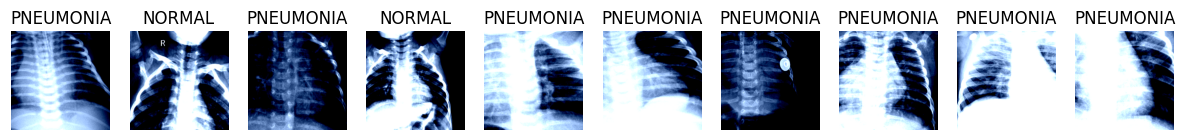

In [26]:
# Visualize some images
def show_images(data_loader, num_images):
    class_names = data_loader.dataset.classes
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.set_title(class_names[labels[idx]])
        ax.axis('off')

    plt.show()

show_images(train_loader, 10)  # Visualize training images

### Image Preprocessing

#### 1. Data Augmentation

#### 2. Train Test Split

### Model build/training

In [22]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init()
        # Define your architecture here

    def forward(self, x):
        # Define the forward pass here
        return x

model = CustomCNN()

AttributeError: 'super' object has no attribute '_CustomCNN__init'

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

### Results / Discussion

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')